In [1]:
import os, argparse, random, json
from pathlib import Path
import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform          # for FCD method-2
import scipy.signal as sg
from tqdm import trange

from whobpyt.data_loader import BOLDDataLoader, DEVICE
from simulators.rww_simulator import RWWSubjectSimulator
from whobpyt.custom_cost_RWW import CostsRWW
from whobpyt.modelfitting import Model_fitting
from whobpyt.models.fc_cnn_disc import FCCNNDisc, LightFCCNN
from whobpyt.utils.fc_tools import bold_to_fc


Using DEVICE = cuda


In [2]:
def corr_lower(a, b):
    """Pearson r between lower-triangle of two FC matrices"""
    tri = np.tril_indices_from(a, k=-1)
    return np.corrcoef(a[tri], b[tri])[0, 1]

def plot_triplet(mats, titles, suptitle, outdir, filename):
    plt.figure(figsize=(9,3))
    for i, (m, t) in enumerate(zip(mats, titles), 1):
        plt.subplot(1, len(mats), i)
        sns.heatmap(m, vmin=-1, vmax=1, cmap='coolwarm',
                    square=True, cbar=False)
        plt.title(t); plt.axis('off')
    plt.suptitle(suptitle); plt.tight_layout();# plt.savefig(f"{outdir}/{filename}")
    plt.show()

def plot_fc(m, title, ax=None):
    if ax is None: fig, ax = plt.subplots(1,1, figsize=(3,3))
    sns.heatmap(m, vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=False, ax=ax)
    ax.set_title(title); ax.axis('off')
    return ax

def build_sim(loader, subj, *, chunk, g=1200,
              fit_g_EE=False, fit_g_EI=True, use_fic=True):
    sc = loader.get_subject_connectome(subj, norm=True)
    sim = RWWSubjectSimulator(
        sc, sc.shape[0], TP_per_window=chunk,
        fit_g_EE=fit_g_EE, fit_g_IE=not use_fic, fit_g_EI=fit_g_EI,
        use_fic=use_fic, step_size=0.05, g_init=g)
    return sim

def load_simulator(simulator_path):
    sim = torch.load(simulator_path, weights_only=False, map_location=DEVICE)
    sim.model.to(DEVICE)
    print(f"Loaded simulator from {simulator_path}")
    print("g  =", sim.model.params.g.val.item())
    print("g_EE =", sim.model.params.g_EE.val.item())
    print("g_EI =", sim.model.params.g_EI.val.item())
    print("g_IE =", sim.model.params.g_IE.val.item())
    print("g_FIC (mean) =", sim.model.params.g_FIC.val.mean().item())
    print("kappa =", sim.model.params.kappa.val.item())
    return sim


In [3]:
data_root = "/vol/bitbucket/ank121/fyp/HCP Data"
weights_dir = "/vol/bitbucket/ank121/whobpyt/whobpyt/trainers/weights/"
sim_save_dir = "/vol/bitbucket/ank121/whobpyt/exp2/sims/"
save_dir = "/vol/bitbucket/ank121/whobpyt/exp2/plots"
subj = 18
chunk = 100
disc_train = 400
gen_weights = "gen_sub018_g1200_chunk100.pt"
disc_weights = f"disc_sub{subj:03d}_len{disc_train}_hinge.pt"

epochs = 50
lr = 0.1
mix_other_subj = False
train_window_length = 900
total_simulation_length = 1500

torch.manual_seed(0); np.random.seed(0); random.seed(0)
fmri = os.path.join(data_root, "BOLD Timeseries HCP.mat")
scdir = os.path.join(data_root, "distance_matrices")
dist  = os.path.join(data_root, "schaefer100_dist.npy")
loader = BOLDDataLoader(fmri, scdir, dist, chunk)
loader._split_into_chunks()

[DataLoader] Loaded 100 subjects.
[DataLoader] Created 1100 chunks (chunk length = 100).


In [4]:
simulator_path = os.path.join(weights_dir, gen_weights)
discriminator_path = os.path.join(weights_dir, f'disc_sub{subj:03d}_len{disc_train}_hinge.pt')

ts_emp = loader.all_bold[subj]
full_emp = bold_to_fc(ts_emp)

In [22]:
disc = LightFCCNN(ts_emp.shape[0]).to(DEVICE)
disc.load_state_dict(torch.load(discriminator_path, map_location=DEVICE))
print(f"Loaded discriminator from {discriminator_path}")
disc.eval() 

Loaded discriminator from /vol/bitbucket/ank121/whobpyt/whobpyt/trainers/weights/disc_sub018_len400_hinge.pt


LightFCCNN(
  (feat): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): LeakyReLU(negative_slope=0.2)
  )
  (clf): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [6]:
def load_simulator(simulator_path):
    sim = torch.load(simulator_path, weights_only=False, map_location=DEVICE)
    sim.model.to(DEVICE)
    print(f"Loaded simulator from {simulator_path}")
    print("g  =", sim.model.params.g.val.item())
    print("g_EE =", sim.model.params.g_EE.val.item())
    print("g_EI =", sim.model.params.g_EI.val.item())
    print("g_IE =", sim.model.params.g_IE.val.item())
    print("g_FIC (mean) =", sim.model.params.g_FIC.val.mean().item())
    print("kappa =", sim.model.params.kappa.val.item())
    return sim

sim_base_path = sim_save_dir + "sim_base.pt"
sim_adv_path = sim_save_dir + "sim_adv.pt"

sim_base = build_sim(loader, subj, chunk=chunk); sim_base.model.to(DEVICE)
# sim_base = load_simulator(sim_base_path)
cost_base = CostsRWW(sim_base.model,
                    use_rate_reg=True,  lambda_rate=0.05,
                    use_spec_reg=True,  lambda_spec=0.05,
                    use_disp_reg=True,  lambda_disp=0.03)

sim_adv = build_sim(loader, subj, chunk=chunk); sim_base.model.to(DEVICE)
# sim_adv = load_simulator(sim_adv_path)
cost_adv = CostsRWW(sim_adv.model,
                    use_rate_reg=True,  lambda_rate=0.05,
                    use_spec_reg=True,  lambda_spec=0.05,
                    use_disp_reg=True,  lambda_disp=0.03)

train_fc = loader.train_fc_windows(subj, win_len=train_window_length)
train_num_windows = total_simulation_length // chunk

if mix_other_subj:
    other = (subj + 1) % loader.num_subjects
    train_fc += loader.train_fc_windows(other, win_len=train_window_length)
    print(f"[+] Augmented with windows from subject {other}")



In [7]:
def fit_model(sim, cost, adv, tag):
    fitter = Model_fitting(sim.model, cost, use_adv=adv, lambda_adv=0.1, disc_path=discriminator_path, device=DEVICE)
    fitter.train(u=0, empFcs=train_fc,
                    num_epochs=epochs,
                    num_windows=train_num_windows,
                    learningrate=lr, early_stopping=True, disc_train_length=disc_train)
    return sim


In [8]:
import sys
import os
from contextlib import redirect_stdout

class Tee:
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush()
    def flush(self):
        for f in self.files:
            f.flush()

os.makedirs("logs/exp2", exist_ok=True)

log_base = open("logs/exp2/base.txt", "w")
tee_base = Tee(sys.stdout, log_base)

log_adv = open("logs/exp2/adv.txt", "w")
tee_adv = Tee(sys.stdout, log_adv)

with redirect_stdout(tee_adv):
    print("\n=== Fitting WITH adversarial loss ===")
    sim_adv = fit_model(sim_adv, cost_adv, True, 'adv')
log_adv.close()

with redirect_stdout(tee_base):
    print("\n=== Fitting WITHOUT adversarial loss ===")
    sim_base = fit_model(sim_base, cost_base, False, 'base')
log_base.close()



=== Fitting WITH adversarial loss ===
offset = 1
[Trainer] Fitting 1 FC matrices with 15 windows of 100 TRs
recon=18.7596  adv=0.0287  disc(p)=-1.437
recon=16.2566  adv=0.0315  disc(p)=-1.573
recon=14.5673  adv=0.0337  disc(p)=-1.684
[1 / 1] FC_cor: 0.081
epoch 000  loss=18.0884  g=1199.979  g_EE=3.500  g_EI=0.713 g_IE=0.420 kappa=0.93
recon=12.1600  adv=0.0565  disc(p)=-1.413
recon=10.7301  adv=0.0659  disc(p)=-1.649
recon=10.0980  adv=0.0614  disc(p)=-1.535
[1 / 1] FC_cor: 0.138
epoch 001  loss=12.2160  g=1200.072  g_EE=3.500  g_EI=0.985 g_IE=0.420 kappa=0.75
recon=9.1801  adv=0.0980  disc(p)=-1.634
recon=8.8472  adv=0.1002  disc(p)=-1.670
recon=9.4884  adv=0.0968  disc(p)=-1.614
[1 / 1] FC_cor: 0.204
epoch 002  loss=9.9196  g=1200.006  g_EE=3.500  g_EI=1.203 g_IE=0.420 kappa=0.58
recon=9.0451  adv=0.1313  disc(p)=-1.641
recon=8.0481  adv=0.1135  disc(p)=-1.419
recon=9.2674  adv=0.1264  disc(p)=-1.581
[1 / 1] FC_cor: 0.329
epoch 003  loss=9.7417  g=1200.054  g_EE=3.500  g_EI=1.327 g

In [9]:
import scipy.stats as ss

def plot_disc_vs_fc(fc_list, label):
    """ Compare D(fake) confidence with FC correlation to ground-truth """
    tri = np.tril_indices_from(full_emp, -1)
    fc_vec_emp = full_emp[tri]
    ps = []
    rs = []
    for fc in fc_list:
        fc_tensor = torch.tensor(fc[None, None], dtype=torch.float32).to(DEVICE)
        p = disc(fc_tensor).item()
        r = ss.pearsonr(fc[tri], fc_vec_emp)[0]
        ps.append(p)
        rs.append(r)
    plt.scatter(rs, ps, alpha=0.6)
    plt.xlabel("Pearson FC corr to empirical")
    plt.ylabel("Discriminator score D(fake)")
    plt.title("D(fake) vs FC correlation to ground-truth")
    plt.grid(True)
    # plt.show()
    plt.savefig(f"{save_dir}/{label}.png")
    print(f"Saved to {save_dir}/{label}.png")
    plt.close()


def simulate_full(sim, label, its=5):
    corrs, p_list, fc_list = [], [], []
    print(f'Testing {label}...')
    for _ in range(its):
        n_win = ts_emp.shape[1] // chunk
        ts_sim, fc_sim = sim.simulate(u=0, num_windows=n_win, base_window_num=10)
        r = corr_lower(fc_sim, full_emp)
        p = disc(torch.tensor(fc_sim, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()
        print(f"r = {r:.3f}, p = {p:.3f}", end=" ")
        corrs.append(r); fc_list.append(fc_sim); p_list.append(p)
    corrs = np.array(corrs); ps = np.array(p_list)
    print(f"\n Corr = {corrs.mean():.3f} +- {corrs.std(ddof=1):.3f}")
    print(f"\n P = {ps.mean():.3f} +- {ps.std(ddof=1):.3f}")
    plot_disc_vs_fc(fc_list, label)
    return ts_sim, fc_sim, corrs.mean()

ts_adv, fc_adv, r_adv = simulate_full(sim_adv,  'ADV', its=10)
ts_base, fc_base, r_base = simulate_full(sim_base, 'BASE', its=10)


Testing ADV...
[Simulator] Simulating 11 windows 


r = 0.625, p = 0.862 [Simulator] Simulating 11 windows 
r = 0.590, p = 0.695 [Simulator] Simulating 11 windows 
r = 0.570, p = 0.239 [Simulator] Simulating 11 windows 
r = 0.603, p = 0.290 [Simulator] Simulating 11 windows 
r = 0.553, p = 0.254 [Simulator] Simulating 11 windows 
r = 0.554, p = 0.176 [Simulator] Simulating 11 windows 
r = 0.605, p = 0.470 [Simulator] Simulating 11 windows 
r = 0.621, p = 0.723 [Simulator] Simulating 11 windows 
r = 0.576, p = 0.029 [Simulator] Simulating 11 windows 
r = 0.617, p = 0.701 
 Corr = 0.591 +- 0.027

 P = 0.444 +- 0.284
Saved to /vol/bitbucket/ank121/whobpyt/exp2/plots/ADV.png
Testing BASE...
[Simulator] Simulating 11 windows 
r = 0.625, p = -0.020 [Simulator] Simulating 11 windows 
r = 0.567, p = -0.300 [Simulator] Simulating 11 windows 
r = 0.622, p = 0.502 [Simulator] Simulating 11 windows 
r = 0.539, p = -0.175 [Simulator] Simulating 11 windows 
r = 0.596, p = -0.023 [Simulator] Simulating 11 windows 
r = 0.561, p = -0.219 [Simulator] Sim

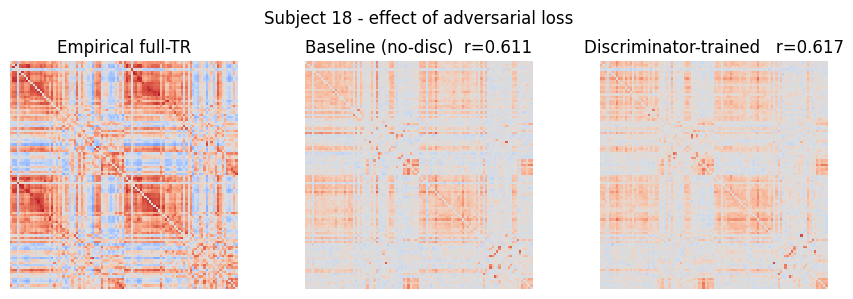

In [23]:
SAVE_DIR = Path("exp2"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
plot_triplet(
    [full_emp, fc_base, fc_adv],
    ['Empirical full-TR',
        f'Baseline (no-disc)  r={r_base:.3f}',
        f'Discriminator-trained   r={r_adv:.3f}'],
    f"Subject {subj} - effect of adversarial loss",
    outdir=SAVE_DIR.name, filename="adv_effect_epochs50.png")


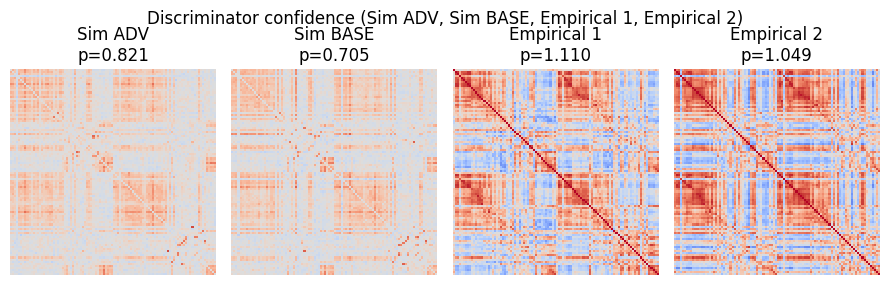

In [24]:
def show_disc_samples():
    # Sample one FC from sim_adv, one from sim_base, and two different empirical FCs
    # with torch.no_grad():
    #     # Simulated (ADV)
    #     _, fc_adv = sim_adv.simulate(u=0, num_windows=2400 // chunk, base_window_num=10)
    #     # Simulated (BASE)
    #     _, fc_base = sim_base.simulate(u=0, num_windows=2400 // chunk, base_window_num=10)

    # Empirical: pick two non-overlapping windows of disc_train size
    ts_emp = loader.all_bold[subj]
    total_T = ts_emp.shape[1]
    win_len = disc_train
    if total_T < 2 * win_len:
        raise ValueError("Not enough timepoints for two non-overlapping empirical FCs")
    # Randomly select two non-overlapping windows
    idx1 = np.random.randint(0, total_T - win_len + 1)
    idx2_choices = list(range(0, idx1 - win_len + 1)) + list(range(idx1 + win_len, total_T - win_len + 1))
    if not idx2_choices:
        idx2 = (idx1 + win_len) % (total_T - win_len + 1)
    else:
        idx2 = np.random.choice(idx2_choices)
    emp_fc1 = bold_to_fc(ts_emp[:, idx1:idx1+win_len])
    emp_fc2 = bold_to_fc(ts_emp[:, idx2:idx2+win_len])

    mats = []
    labels = []

    # Simulated ADV
    mats.append(fc_adv)
    p_adv = disc(torch.tensor(fc_adv, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()
    labels.append(f"Sim ADV\np={p_adv:.3f}")

    # Simulated BASE
    mats.append(fc_base)
    p_base = disc(torch.tensor(fc_base, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()
    labels.append(f"Sim BASE\np={p_base:.3f}")

    # Empirical 1
    mats.append(emp_fc1)
    p_emp1 = disc(torch.tensor(emp_fc1, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()
    labels.append(f"Empirical 1\np={p_emp1:.3f}")

    # Empirical 2
    mats.append(emp_fc2)
    p_emp2 = disc(torch.tensor(emp_fc2, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()
    labels.append(f"Empirical 2\np={p_emp2:.3f}")

    plot_triplet(
        mats, labels,
        "Discriminator confidence (Sim ADV, Sim BASE, Empirical 1, Empirical 2)",
        outdir=save_dir, filename="samples_epochs20.png"
    )
show_disc_samples()

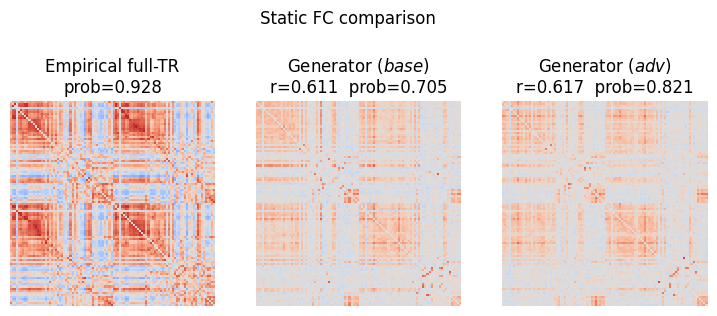

In [25]:
r_base = corr_lower(full_emp, fc_base)
disc_base = disc(torch.tensor(fc_base, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()
r_adv  = corr_lower(full_emp, fc_adv)
disc_adv = disc(torch.tensor(fc_adv, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()
disc_emp = disc(torch.tensor(full_emp, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)).item()

fig,axs = plt.subplots(1,3, figsize=(9,4))
plot_fc(full_emp,  f"Empirical full-TR\nprob={disc_emp:.3f}", axs[0])
plot_fc(fc_base, f"Generator ($base$)\nr={r_base:.3f}  prob={disc_base:.3f}", axs[1])
plot_fc(fc_adv,  f"Generator ($adv$)\nr={r_adv:.3f}  prob={disc_adv:.3f}",  axs[2])
plt.suptitle("Static FC comparison"); plt.show()
# plt.savefig(save_dir + '/' + '01static_fc.png')

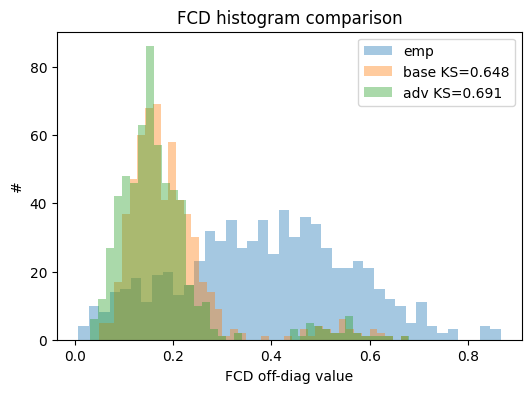

In [26]:
def fcd_matrix(ts, win=60, step=30):
    N, T = ts.shape
    tri = np.tril_indices(N, -1)
    vecs=[]
    for s in range(0, T-win+1, step):
        vecs.append(np.corrcoef(ts[:, s:s+win])[tri])
    vecs = np.stack(vecs)
    F = np.corrcoef(vecs)
    tri_f = np.triu_indices_from(F, 1)
    return F[tri_f]

F_emp  = fcd_matrix(ts_emp)
F_base = fcd_matrix(ts_base)
F_adv  = fcd_matrix(ts_adv)

ks_base = ss.ks_2samp(F_emp, F_base).statistic
ks_adv  = ss.ks_2samp(F_emp, F_adv).statistic

plt.figure(figsize=(6,4))
plt.hist(F_emp,  bins=40, alpha=.4, label="emp")
plt.hist(F_base, bins=40, alpha=.4, label=f"base KS={ks_base:.3f}")
plt.hist(F_adv,  bins=40, alpha=.4, label=f"adv KS={ks_adv:.3f}")
plt.legend(); plt.xlabel("FCD off-diag value"); plt.ylabel("#")
plt.title("FCD histogram comparison"); plt.show()
# plt.savefig(save_dir + '/' + '02fcd_ks.png')


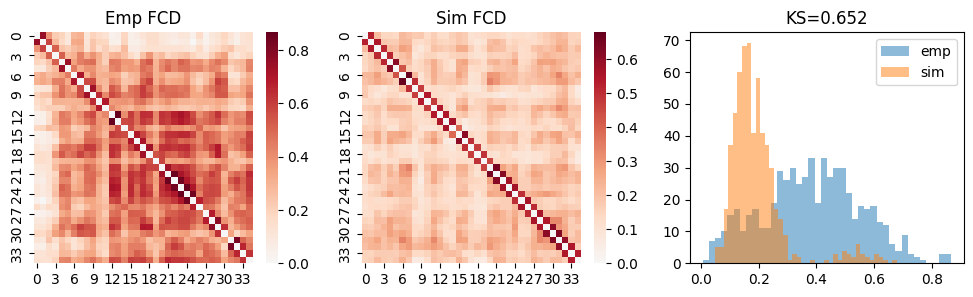

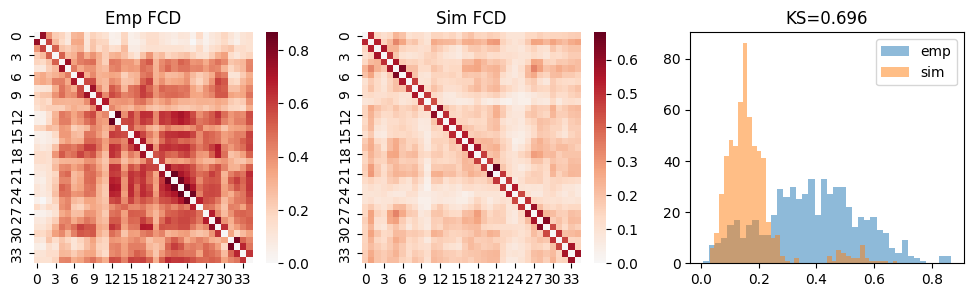

FCD-KS  base=0.652  adv=0.696


In [14]:
def fcd_ks(ts_ref, ts_sim, win=60, step=30, ax=None):
    def fc_vecs(x):
        tri = np.tril_indices(x.shape[0], -1)
        idx = range(0, x.shape[1]-win+1, step)
        return np.stack([np.corrcoef(x[:,s:s+win])[tri] for s in idx])

    V_ref = fc_vecs(ts_ref)
    V_sim = fc_vecs(ts_sim[:,:ts_ref.shape[1]])

    # corr distance matrix (faster than np.corrcoef)
    F_ref = squareform(1-pdist(V_ref, metric='correlation'))
    F_sim = squareform(1-pdist(V_sim, metric='correlation'))

    tri = np.triu_indices_from(F_ref, 1)
    ks  = ss.ks_2samp(F_ref[tri], F_sim[tri]).statistic

    if ax is None: fig,ax = plt.subplots(1,3,figsize=(12,3))
    sns.heatmap(F_ref,cmap='RdBu_r',center=0,ax=ax[0]); ax[0].set_title('Emp FCD')
    sns.heatmap(F_sim,cmap='RdBu_r',center=0,ax=ax[1]); ax[1].set_title('Sim FCD')
    ax[2].hist(F_ref[tri],40,alpha=.5,label='emp')
    ax[2].hist(F_sim[tri],40,alpha=.5,label='sim'); ax[2].legend()
    ax[2].set_title(f'KS={ks:.3f}')
    plt.show(); return ks

ks_base = fcd_ks(ts_emp[:, :ts_adv.shape[1]], ts_base)
ks_adv  = fcd_ks(ts_emp[:, :ts_adv.shape[1]], ts_adv )
print(f"FCD-KS  base={ks_base:.3f}  adv={ks_adv:.3f}")


In [47]:
def fc_vecs(ts, win=60, step=60):
    N, T = ts.shape; 
    tri=np.tril_indices(N, -1); out=[]
    for s in range(0, T-win+1, step):
        out.append(np.corrcoef(ts[:,s:s+win])[tri])
    return np.stack(out)

def dwell_and_transition(ts_emp, ts_sim, k=5, win=60):
    V_emp = fc_vecs(ts_emp, win, win)
    V_sim = fc_vecs(ts_sim, win, win)
    km = KMeans(k, n_init=50, random_state=0).fit(V_emp)
    lab_emp = km.predict(V_emp); lab_sim = km.predict(V_sim)

    def dwell(l): 
        c=np.bincount(l, minlength=k)
        return c/c.sum()
    d_emp, d_sim = dwell(lab_emp), dwell(lab_sim)
    dwell_l1=np.abs(d_emp-d_sim).sum()

    def trans(l):
        M = np.ones((k,k))
        for a,b in zip(l[:-1],l[1:]): M[a,b]+=1
        return M / M.sum(1,keepdims=True)
    P_emp, P_sim = trans(lab_emp), trans(lab_sim)
    trans_fro = np.linalg.norm(P_emp-P_sim)
    return dwell_l1, trans_fro

dw_l1_b, tr_b = dwell_and_transition(ts_emp, ts_base)
dw_l1_a, tr_a = dwell_and_transition(ts_emp, ts_adv)
print(f"Dwell L1   base={dw_l1_b:.3f} | adv={dw_l1_a:.3f}")
print(f"Trans Fro  base={tr_b:.3f}   | adv={tr_a:.3f}")


Dwell L1   base=1.047 | adv=1.363
Trans Fro  base=0.624   | adv=0.679


/tmp/ipykernel_3547114/1094621795.py:18: RuntimeWarning: invalid value encountered in divide
  P=P/P.sum(1,keepdims=True); P[np.isnan(P)]=0; return P


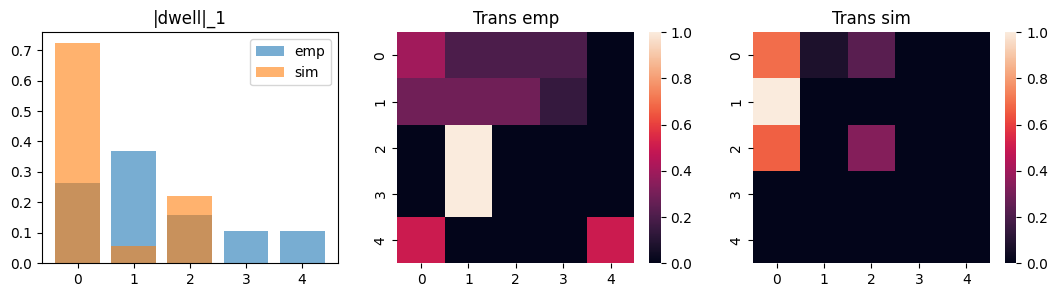

/tmp/ipykernel_3547114/1094621795.py:18: RuntimeWarning: invalid value encountered in divide
  P=P/P.sum(1,keepdims=True); P[np.isnan(P)]=0; return P


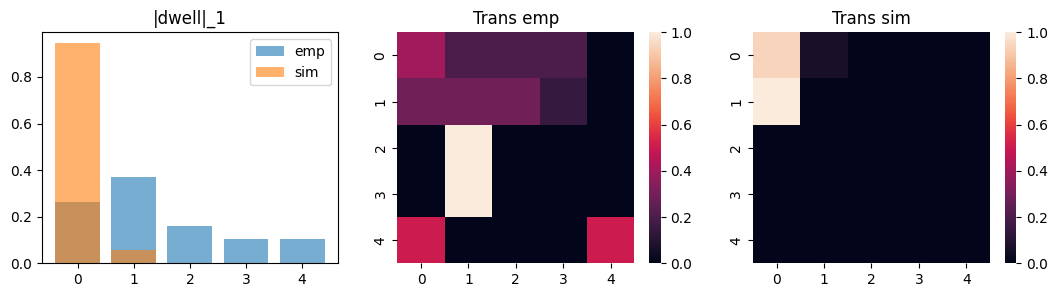

Dwell-L1  base=1.047 adv=1.363
ΔP_Frob  base=1.973 adv=1.893


In [15]:
def dwell_and_trans_err(ts_ref, ts_sim, n_states=5, win=60):
    def vecs(x):
        tri = np.tril_indices(x.shape[0],-1)
        idx = range(0,x.shape[1]-win+1,win)
        return np.stack([np.corrcoef(x[:,s:s+win])[tri] for s in idx])

    V_ref, V_sim = vecs(ts_ref), vecs(ts_sim[:,:ts_ref.shape[1]])
    km = KMeans(n_states,n_init=50,random_state=0).fit(V_ref)
    lab_r, lab_s = km.predict(V_ref), km.predict(V_sim)

    def dwell(lbl,k): c=np.bincount(lbl,minlength=k).astype(float); return c/c.sum()
    d_r,d_s = dwell(lab_r,n_states), dwell(lab_s,n_states)
    dwell_L1 = np.abs(d_r-d_s).sum()

    def trans(lbl,k):
        P = np.zeros((k,k))
        for a,b in zip(lbl[:-1],lbl[1:]): P[a,b]+=1
        P=P/P.sum(1,keepdims=True); P[np.isnan(P)]=0; return P
    P_r,P_s=trans(lab_r,n_states),trans(lab_s,n_states)
    frob = np.linalg.norm(P_r-P_s)

    # ---- plot
    fig,ax=plt.subplots(1,3,figsize=(13,3))
    ax[0].bar(range(n_states),d_r,alpha=.6,label='emp')
    ax[0].bar(range(n_states),d_s,alpha=.6,label='sim'); ax[0].legend(); ax[0].set_title('|dwell|_1')
    sns.heatmap(P_r,vmin=0,vmax=P_r.max(),ax=ax[1]); ax[1].set_title('Trans emp')
    sns.heatmap(P_s,vmin=0,vmax=P_r.max(),ax=ax[2]); ax[2].set_title('Trans sim')
    plt.show(); return dwell_L1,frob

dL1_b,frob_b = dwell_and_trans_err(ts_emp, ts_base)
dL1_a,frob_a = dwell_and_trans_err(ts_emp, ts_adv )
print(f"Dwell-L1  base={dL1_b:.3f} adv={dL1_a:.3f}")
print(f"ΔP_Frob  base={frob_b :.3f} adv={frob_a :.3f}")


In [16]:
def beta_power(ts, fs=1/0.72, f_lo=0.01, f_hi=0.1):
    T = ts.shape[1]
    fft = np.fft.rfft(ts - ts.mean(1, keepdims=True), axis=1)
    psd = (fft.real**2 + fft.imag**2).mean(0)
    freqs = np.fft.rfftfreq(T, 1/fs)
    msk = (freqs>=f_lo)&(freqs<=f_hi)
    x = np.log(freqs[msk]); y = np.log(psd[msk])
    beta = -np.polyfit(x, y, 1)[0]
    return beta

β_emp  = beta_power(ts_emp)
β_base = beta_power(ts_base)
β_adv  = beta_power(ts_adv)

print(f"β   emp={β_emp:.2f} | base={β_base:.2f} | adv={β_adv:.2f}")


β   emp=1.69 | base=1.02 | adv=0.90


|Δβ|  base=1.474  adv=1.580


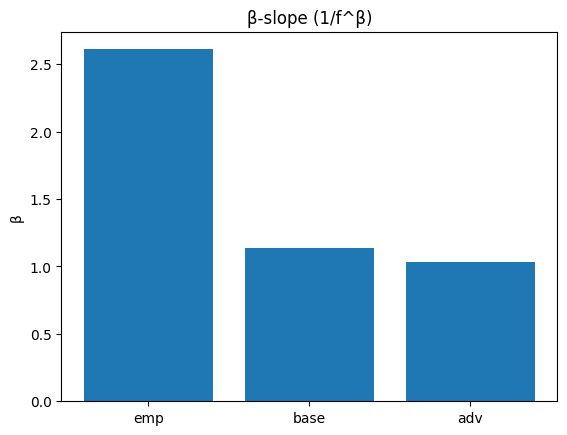

In [17]:
def beta(ts, fs=1/0.72, f_lo=.02, f_hi=.1):
    f,P = sg.welch(ts,fs,nperseg=ts.shape[1]//4,axis=1)
    band = (f>=f_lo)&(f<=f_hi)
    x,y = np.log(f[band]), np.log(P.mean(0)[band])
    b,_ = np.polyfit(x,y,1); return -b

b_emp = beta(ts_emp)
b_bas = beta(ts_base[:,:ts_emp.shape[1]])
b_adv = beta(ts_adv [:,:ts_emp.shape[1]])

plt.figure(); plt.bar(['emp','base','adv'],[b_emp,b_bas,b_adv])
plt.title('β-slope (1/f^β)'); plt.ylabel('β')
print(f"|Δβ|  base={abs(b_emp-b_bas):.3f}  adv={abs(b_emp-b_adv):.3f}")


In [18]:
import networkx as nx
def graph_metrics(fc):
    np.fill_diagonal(fc,0); W=np.abs(fc)
    G=nx.from_numpy_array(W)
    C  = np.mean(list(nx.clustering(G,weight='weight').values()))
    E  = nx.global_efficiency(G)
    comm = nx.algorithms.community.louvain_communities(G,weight='weight',seed=0)
    Q  = nx.algorithms.community.modularity(G,comm,weight='weight')
    return dict(C=C,Eglob=E,Q=Q)

m_emp = graph_metrics(full_emp)
m_bas = graph_metrics(fc_base)
m_adv = graph_metrics(fc_adv)

for k in m_emp:
    print(f"{k:5}: emp={m_emp[k]:.3f}  baseΔ={abs(m_emp[k]-m_bas[k]):.3f}  advΔ={abs(m_emp[k]-m_adv[k]):.3f}")


C    : emp=0.268  baseΔ=0.148  advΔ=0.161
Eglob: emp=1.000  baseΔ=0.000  advΔ=0.000
Q    : emp=0.138  baseΔ=0.041  advΔ=0.037


Text(0.5, 1.0, 'α-band power topography')

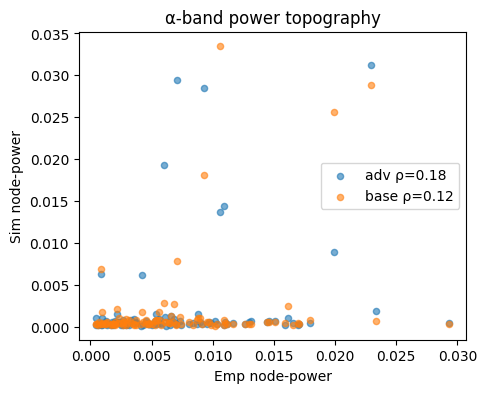

In [37]:
def band_power(ts,band,fs=1/0.72):
    b,a=sg.butter(3,np.array(band)/(fs/2),'band'); p=sg.filtfilt(b,a,ts,axis=1)**2
    return p.mean(1)

p_emp = band_power(ts_emp,(8/1000,12/1000))
p_bas = band_power(ts_base[:,:ts_emp.shape[1]],(12/1000,20/1000))
p_adv = band_power(ts_adv [:,:ts_emp.shape[1]],(12/1000,20/1000))

ρ_bas = ss.spearmanr(p_emp,p_bas).correlation
ρ_adv = ss.spearmanr(p_emp,p_adv).correlation
plt.figure(figsize=(5,4)); plt.scatter(p_emp,p_adv,s=20,alpha=.6,label=f'adv ρ={ρ_adv:.2f}')
plt.scatter(p_emp,p_bas,s=20,alpha=.6,label=f'base ρ={ρ_bas:.2f}')
plt.xlabel('Emp node-power'); plt.ylabel('Sim node-power'); plt.legend(); plt.title('α-band power topography')


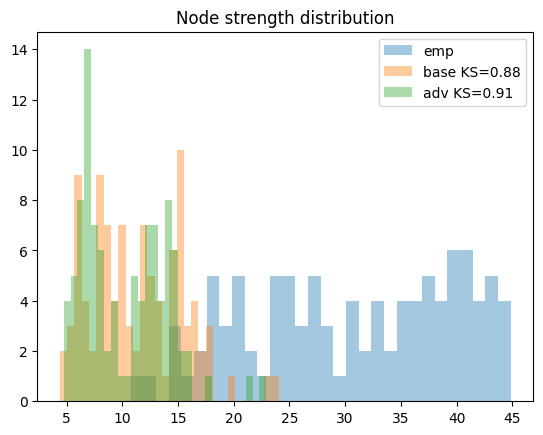

In [16]:
def strength_dist(fc):
    w = np.abs(fc).copy(); np.fill_diagonal(w,0)
    return w.sum(0)

S_emp, S_base, S_adv = map(strength_dist, [full_emp, fc_base, fc_adv])
ks_s_base = ss.ks_2samp(S_emp, S_base).statistic
ks_s_adv  = ss.ks_2samp(S_emp, S_adv).statistic
plt.hist(S_emp, 30, alpha=.4, label='emp')
plt.hist(S_base,30, alpha=.4, label=f'base KS={ks_s_base:.2f}')
plt.hist(S_adv, 30, alpha=.4, label=f'adv KS={ks_s_adv :.2f}')
plt.legend(); plt.title("Node strength distribution"); #plt.show()
plt.savefig(save_dir + '/' + '03strength_dist.png')


[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulating 10 windows 
[Simulator] Simulati

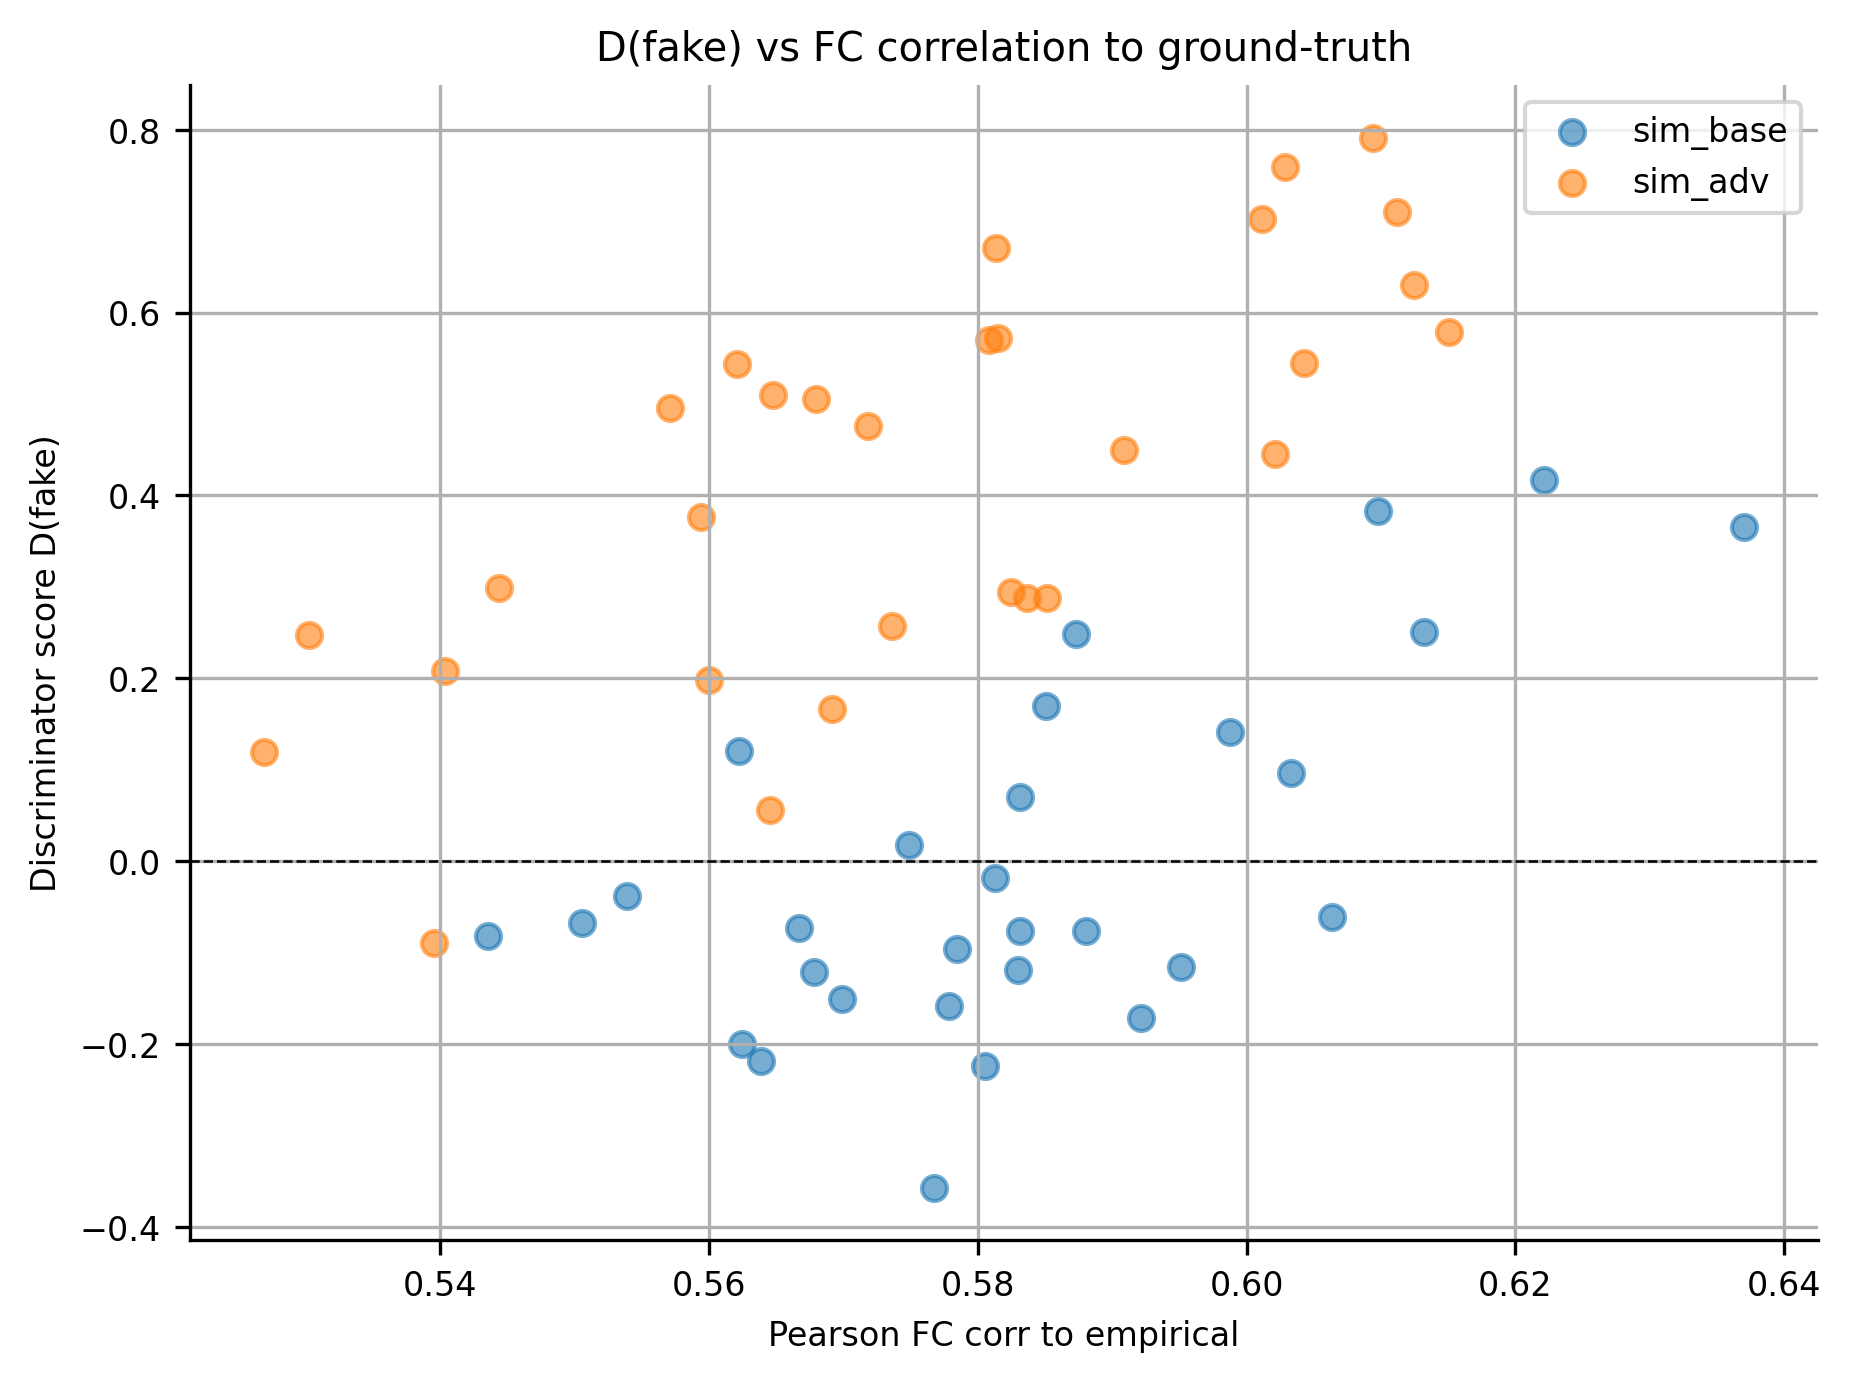

Saved to /vol/bitbucket/ank121/whobpyt/exp2/plots/E2_disc_vs_fc_30.png


In [40]:
num_simulations = 30

# Simulate FCs for both sim_base and sim_adv
fcs_sample_base = [sim_base.simulate(u=0, num_windows=10, base_window_num=5)[1] for _ in range(num_simulations)]
fcs_sample_adv  = [sim_adv.simulate(u=0, num_windows=10, base_window_num=5)[1]  for _ in range(num_simulations)]

def plot_disc_vs_fc_multi(fc_lists, labels, colors, full_emp, disc, save_dir, fname):
    """ Compare D(fake) confidence with FC correlation to ground-truth for multiple sets """
    tri = np.tril_indices_from(full_emp, -1)
    fc_vec_emp = full_emp[tri]
    stats = {}
    plt.figure(figsize=(7,5))
    for fc_list, label, color in zip(fc_lists, labels, colors):
        ps = []
        rs = []
        for fc in fc_list:
            fc_tensor = torch.tensor(fc[None, None], dtype=torch.float32).to(DEVICE)
            p = disc(fc_tensor).item()
            r = ss.pearsonr(fc[tri], fc_vec_emp)[0]
            ps.append(p)
            rs.append(r)
        plt.scatter(rs, ps, alpha=0.6, label=label, color=color)
        stats[label] = {
            "pearson_mean": np.mean(rs),
            "pearson_std": np.std(rs),
            "d_fake_mean": np.mean(ps),
            "d_fake_std": np.std(ps),
        }
        print(f"Stats for {label}:")
        print(f"  Pearson corr: mean={np.mean(rs):.3f}, std={np.std(rs):.3f}")
        print(f"  D(fake):      mean={np.mean(ps):.3f}, std={np.std(ps):.3f}")
    plt.xlabel("Pearson FC corr to empirical")
    plt.ylabel("Discriminator score D(fake)")
    plt.title("D(fake) vs FC correlation to ground-truth")
    plt.axhline(0,ls="--",c="k",lw=.6)
    plt.grid(True)
    plt.legend()

    plt.savefig(f"{save_dir}/{fname}.png")
    plt.show()
    print(f"Saved to {save_dir}/{fname}.png")
    plt.close()
    return stats

stats = plot_disc_vs_fc_multi(
    [fcs_sample_base, fcs_sample_adv],
    ["sim_base", "sim_adv"],
    ["tab:blue", "tab:orange"],
    full_emp, disc, save_dir, f"E2_disc_vs_fc_{num_simulations}"
)

In [28]:
# MARK: Report logging

import numpy as np, scipy.stats as ss, scipy.signal as sg, matplotlib.pyplot as plt
import networkx as nx, seaborn as sns
from pathlib import Path
plt.rcParams.update({
    "font.size": 8, "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 300, "savefig.bbox": "tight"
})

WIN, STEP = 60, 30                  # for FCD & state windows (TR)
BAND_META = (0.04, 0.07)            # Kuramoto band
FS_BOLD   = 1/0.72                  # sampling rate [Hz]

def _tri(mat):                               # vectorised lower-triangle indices
    i = np.tril_indices_from(mat, -1)
    return mat[i]

def _fc(ts):
    return np.corrcoef(ts)

OUTDIR = Path("/vol/bitbucket/ank121/whobpyt/exp2/plots")
OUTDIR.mkdir(parents=True, exist_ok=True)

In [29]:
def plot_fcd_hist(ts_emp, ts_base, ts_adv, outdir):
    def fc_vec(ts):
        tri = np.tril_indices(ts.shape[0], -1)
        idx = range(0, ts.shape[1]-WIN+1, STEP)
        return np.stack([_fc(ts[:,s:s+WIN])[tri] for s in idx])
    V_e, V_b, V_a = map(fc_vec, (ts_emp, ts_base, ts_adv))
    F_e, F_b, F_a = map(np.corrcoef, (V_e, V_b, V_a))
    tri = np.triu_indices_from(F_e, 1)
    ks_b = ss.ks_2samp(F_e[tri], F_b[tri]).statistic
    ks_a = ss.ks_2samp(F_e[tri], F_a[tri]).statistic

    plt.figure(figsize=(4,3))
    plt.hist(F_e[tri], bins=50, alpha=.6, label="emp", density=False)
    plt.hist(F_b[tri], bins=50, alpha=.4, label=f"base KS={ks_b:.3f}")
    plt.hist(F_a[tri], bins=50, alpha=.4, label=f"adv KS={ks_a:.3f}")
    plt.title("FCD histogram comparison"); plt.xlabel("FCD off-diag value"); plt.ylabel("#")
    plt.legend()
    # plt.show(); plt.close()
    plt.savefig(outdir/"E2_FCD_hist.png"); plt.close()

plot_fcd_hist(ts_emp[:, :ts_base.shape[1]], ts_base, ts_adv, OUTDIR)

In [35]:
def plot_strength(fc_emp, fc_base, fc_adv, outdir):
    def strength(fc): return fc.sum(0)
    se, sb, sa = map(strength, (fc_emp, fc_base, fc_adv))
    ks_b = ss.ks_2samp(se, sb).statistic
    ks_a = ss.ks_2samp(se, sa).statistic

    plt.figure(figsize=(4,3))
    plt.hist(se, bins=30, alpha=.6, label="$emp$")
    plt.hist(sb, bins=30, alpha=.5, label=f"$base$ KS={ks_b:.2f}")
    plt.hist(sa, bins=30, alpha=.5, label=f"$adv$ KS={ks_a:.2f}")
    plt.title("Node strength distribution"); plt.xlabel("node strength"); plt.ylabel("#")
    plt.legend(); plt.savefig(outdir/"E2_strength_hist.png"); plt.close()

plot_strength(full_emp, fc_base, fc_adv, OUTDIR)


In [36]:
def plot_psd_beta(ts_emp, ts_base, ts_adv, outdir):
    def beta(ts):
        f, P = sg.welch(ts, fs=FS_BOLD, nperseg=ts.shape[1]//4, axis=1)
        band = (f>=.02)&(f<=.10); x=np.log(f[band]); y=np.log(P.mean(0)[band])
        b,_ = np.polyfit(x,y,1); return -b, f, P.mean(0)
    (be,f,Pe), (bb,_,Pb), (ba,_,Pa) = map(beta,(ts_emp,ts_base,ts_adv))

    plt.figure(figsize=(4,3))
    plt.loglog(f,Pe,label=f"emp β={be:.2f}",lw=1.6)
    plt.loglog(f,Pb,label=f"base β={bb:.2f}",lw=1.2)
    plt.loglog(f,Pa,label=f"adv β={ba:.2f}",lw=1.2)
    plt.axvspan(.02,.10,color='k',alpha=.05); plt.xlabel("Hz"); plt.ylabel("Power")
    plt.title("Mean BOLD PSD"); plt.legend()
    plt.savefig(outdir/"E2_PSD.png"); plt.close()
    # plt.show(); plt.close()

plot_psd_beta(ts_emp[:, :ts_base.shape[1]], ts_base, ts_adv, OUTDIR)


In [46]:
def plot_graph_bars(fc_emp, fc_base, fc_adv, outdir):
    def metrics(fc):
        A=fc.copy(); np.fill_diagonal(A,0); A[A<0]=0
        G=nx.from_numpy_array(A)
        C=np.mean(list(nx.clustering(G,weight='weight').values()))
        E=nx.global_efficiency(G)
        Q=nx.algorithms.community.modularity(G,
              nx.algorithms.community.louvain_communities(G,weight='weight',seed=0),
              weight='weight')
        return C,E,Q
    C_e,E_e,Q_e = metrics(fc_emp)
    C_b,E_b,Q_b = metrics(fc_base)
    C_a,E_a,Q_a = metrics(fc_adv)
    labs = ["Clustering","Efficiency","Modularity"]
    x = np.arange(3); w = .25
    plt.figure(figsize=(4,3))
    plt.bar(x-w, [C_e,E_e,Q_e], w,label="emp", color="#ff7c72")
    plt.bar(x  , [C_b,E_b,Q_b], w,label="base", color="#dd188b")
    plt.bar(x+w, [C_a,E_a,Q_a], w,label="adv", color="#33bf7b")
    plt.xticks(x, labs, rotation=20); plt.ylabel("value"); plt.legend()
    plt.title("Weighted graph topology"); plt.ylim(0,1)
    plt.savefig(outdir/"E2_graph_bars.png"); plt.close()
    # plt.show(); plt.close()

plot_graph_bars(full_emp, fc_base, fc_adv, OUTDIR)


In [38]:
def plot_metastability(ts_emp, ts_base, ts_adv, outdir):
    def R_time(ts):
        b,a=sg.butter(3,np.array(BAND_META)/(FS_BOLD/2),'band')
        phase=np.angle(sg.hilbert(sg.filtfilt(b,a,ts,axis=1)))
        R=np.abs(np.mean(np.exp(1j*phase),axis=0)); return R.std(),R
    se,Re  = R_time(ts_emp)
    sb,Rb  = R_time(ts_base)
    sa,Ra  = R_time(ts_adv)

    plt.figure(figsize=(4,2.1))
    plt.plot(Re,label=f"emp σ={se:.3f}",lw=.8)
    plt.plot(Rb,label=f"base σ={sb:.3f}",lw=.8)
    plt.plot(Ra,label=f"adv σ={sa:.3f}",lw=.8)
    plt.ylabel("Kuramoto R"); plt.xlabel("t (TR)")
    plt.title("Metastability trajectories"); plt.legend()
    plt.savefig(outdir/"E2_metastability.png"); plt.close()
    # plt.show(); plt.close()

plot_metastability(ts_emp, ts_base, ts_adv, OUTDIR)

In [ ]:
def plot_disc_vs_fc(corr_base, disc_base, corr_adv, disc_adv, outdir):
    plt.figure(figsize=(4,3))
    plt.scatter(corr_base, disc_base, alpha=.7, label="sim_base")
    plt.scatter(corr_adv , disc_adv , alpha=.7, label="sim_adv")
    plt.axhline(0,ls="--",c="k",lw=.6)
    plt.xlabel("Pearson FC corr to empirical"); plt.ylabel("Discriminator score $D$ (fake)")
    plt.title("$D$(fake) vs FC similarity"); plt.legend()
    plt.savefig(outdir/"E2_disc_vs_fc.png"); plt.close()

In [39]:
torch.save(sim_base, sim_save_dir + "sim_base.pt")
torch.save(sim_adv, sim_save_dir + "sim_adv.pt")